2650227.5
2696841.75
2680006.75
2621308.75
2592687.25
2691175.25
2635755.5
2622929.5
2720515.5
2706616.25
2550466.25
2577389.5
2710282.0
2676731.5
2685582.0
2599330.25
2644938.25
2767393.75
2635590.0
2674719.25
2663783.75
2733027.25
2632959.25
2560440.25
2637563.75
2605796.0
2615493.0
2602720.5
2623417.0
2698183.75
2584832.5
2718737.5
2624459.25
2721891.75
2652273.25
2561178.25
2689181.0
2662464.5
2652294.75
2622871.5
2614306.0
2630302.75
2701095.0
2625072.75
2646758.75
2738410.75
2601459.25
2580519.0
2670757.5
2574678.5
2714278.75
2643302.5
2722003.25
2665178.25
2641990.5
2691980.5
2692370.25
2643303.75
2634431.75
2689774.25
2658345.0
2675979.0
2602832.25
2611457.75
2615591.5
2631420.5
2593664.75
2639546.5
2641203.25
2696393.25
2702622.5
2617542.25
2527440.0
2600834.5
2657344.25
2576586.75
2670978.5
2636130.5
2609961.5
2654847.25
2665352.5
2588034.75
2672944.5
2534295.75
2574981.5
2608400.5
2576336.75
2601983.75
2571735.75
2636325.0
2653305.75
2622315.75
2663620.0
2493470.0
2542403.25

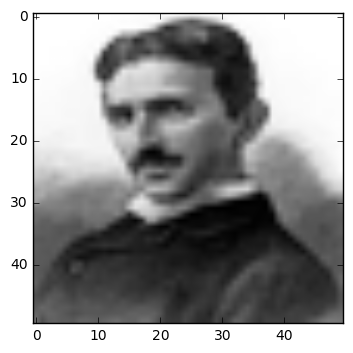

[ 255.  255.  255. ...,  101.  100.   97.]
[[  1.63624725e+01   1.46293223e+00   9.99999997e-07 ...,   9.99999997e-07
    8.36341667e+00   7.39969206e+00]]


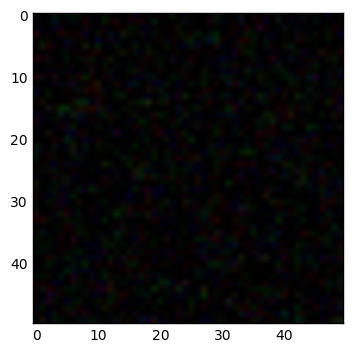

http://listverse.com/wp-content/uploads/2009/02/godfreykneller-isaacnewton-1689.jpg.jpeg


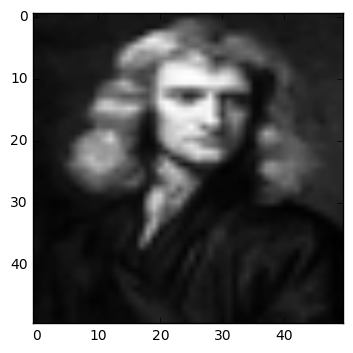

[ 36.  35.  37. ...,  29.  27.  24.]
[[  6.24782085e+00   9.99999997e-07   9.99999997e-07 ...,   3.61538649e+00
    2.65138745e+00   9.99999997e-07]]


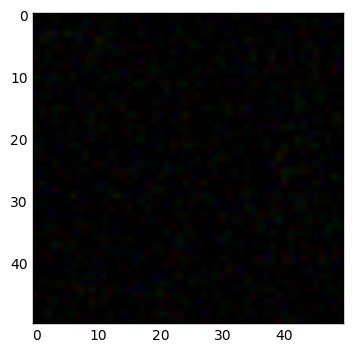

http://listverse.com/wp-content/uploads/2009/02/godfreykneller-isaacnewton-1689.jpg.jpeg


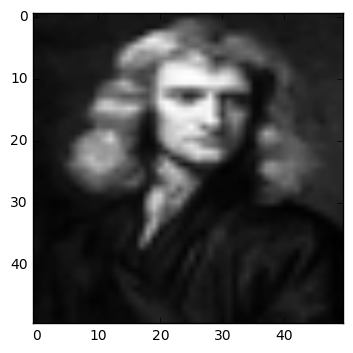

[ 36.  35.  37. ...,  29.  27.  24.]
[[  3.44710183e+00   9.99999997e-07   9.99999997e-07 ...,   4.91044378e+00
    2.29149532e+00   9.99999997e-07]]


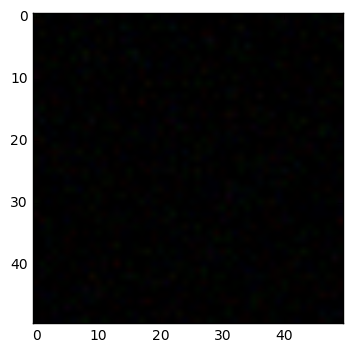

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd660e4b089801fe7e3d9/1458152617516/SciSource_BK0929.jpg?format=750w


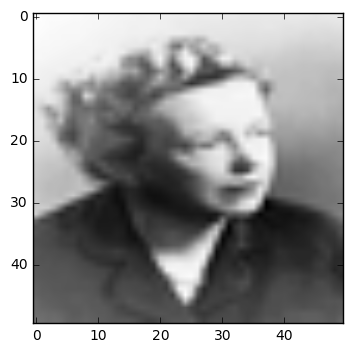

[ 233.  231.  229. ...,   70.   69.   79.]
[[  9.99999997e-07   6.31396484e+00   9.99999997e-07 ...,   9.99999997e-07
    1.63376122e+01   6.20958996e+00]]


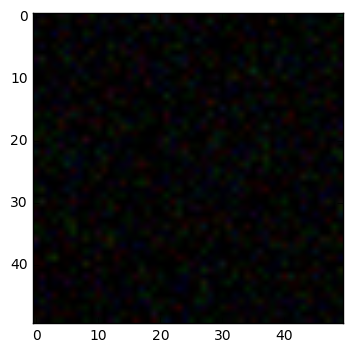

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd28be4b0c47638e2f540/1458152692173/SciSource_BN4337.jpg?format=750w


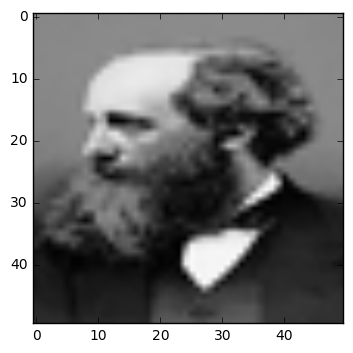

[ 113.  114.  115. ...,   41.   40.   40.]
[[  9.99999997e-07   9.99999997e-07   6.91641140e+00 ...,   7.86776447e+00
    9.99999997e-07   9.99999997e-07]]


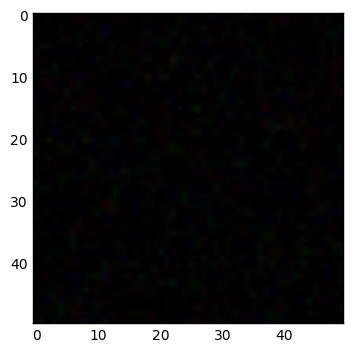

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/53cfd532e4b0141d9ac95e95/1458152729573/SciSource_BK0945.jpg?format=750w


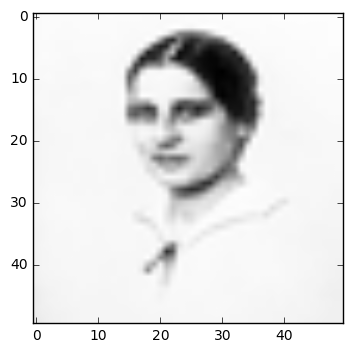

[ 246.  248.  250. ...,  226.  226.  226.]
[[  1.54889126e+01   1.36830473e+01   9.99999997e-07 ...,   9.99999997e-07
    7.61625290e+00   1.75091171e+01]]


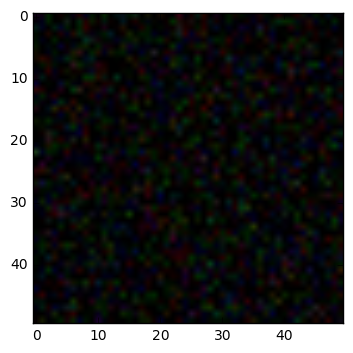

https://static1.squarespace.com/static/51cdd10de4b08819bd7bc9b4/525d89c2e4b0f8245cabfc96/5400dbd4e4b0fc8cd2ef213e/1458152745999/SciSource_BU1440.jpg?format=750w


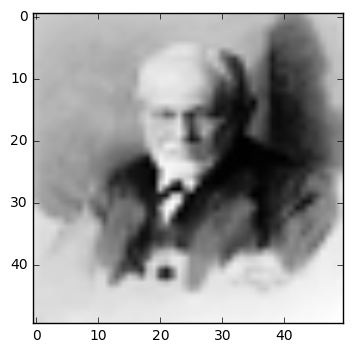

[ 182.  177.  176. ...,  251.  253.  255.]
[[  9.99999997e-07   9.99999997e-07   1.19630785e+01 ...,   1.34291706e+01
    1.27491128e+00   9.99999997e-07]]


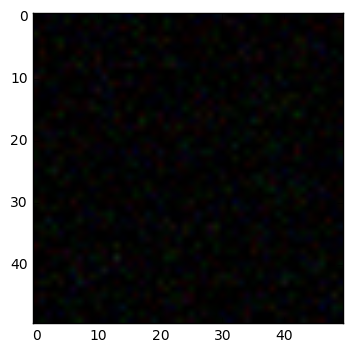

In [38]:
import theano 
from theano import tensor as T 
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
from theano.compile.nanguardmode import NanGuardMode

srng = RandomStreams()

def dropout(X, p=0.): 
    if p > 0: 
        retain_prob = 1 - p 
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX) 
        X /= retain_prob 
    return X 

def rectify(X): 
    return T.maximum(X, 0.000001) 

def softmax(X):     
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x')) 
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x') 

def log_softmax(q):
    max_q = max(0.0, np.max(q))
    rebased_q = q - max_q
    return rebased_q - np.logaddexp(-max_q, np.logaddexp.reduce(rebased_q))

def floatX(X): 
    return np.asarray(X, dtype=theano.config.floatX) 

def init_weights(shape): 
    return theano.shared(floatX(np.random.randn(*shape) * 0.01)) 

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6): 
    grads = T.grad(cost=cost, wrt=params) 
    updates = [] 
    for p, g in zip(params, grads): 
        acc = theano.shared(p.get_value() * 0.) 
        acc_new = rho * acc + (1 - rho) * g ** 2 
        gradient_scaling = T.sqrt(acc_new + epsilon) 
        g = g / gradient_scaling 
        updates.append((acc, acc_new)) 
        updates.append((p, p - lr * g)) 
    return updates 

w_h1 = init_weights((2500, 1000)) 
w_h2 = init_weights((1000, 1000)) 
w_h3 = init_weights((1000, 1000)) 
w_h4 = init_weights((1000, 1000)) 
w_h5 = init_weights((1000, 7500)) 

def model(X,w_h1,w_h2,w_h3,w_h4, w_h5, p_drop_input=0.0, p_drop_hidden=0.0):
    X = dropout(X, p_drop_input) 
    w_o_h1=rectify(T.dot(X, w_h1)) 
    w_o_h1= dropout(w_o_h1, p_drop_input) 
    w_o_h2=rectify(T.dot(w_o_h1, w_h2)) 
    w_o_h2= dropout(w_o_h2, p_drop_input) 
    w_o_h3=rectify(T.dot(w_o_h2, w_h3)) 
    w_o_h3= dropout(w_o_h3, p_drop_input) 
    w_o_h4=rectify(T.dot(w_o_h3, w_h4)) 
    w_o_h4= dropout(w_o_h4, p_drop_input)     
    y_x = rectify(T.dot(w_o_h4, w_h5)) 
    return y_x 


X = T.fmatrix() 
Y = T.fmatrix() 

y_x = model(X,w_h1,w_h2,w_h3,w_h4, w_h5, 0.8,0.8)

cost = T.mean(T.nnet.categorical_crossentropy(y_x, Y))
params = [w_h1,w_h2,w_h3]
updates = RMSprop(cost, params, lr=0.0001) 
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True) 
predict = theano.function(inputs=[X], outputs=y_x, mode=NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True),allow_input_downcast=True) 

import PIL
from PIL import Image
import requests
from io import BytesIO

images = dict()

for i in range(100):
    with open("../Environment/Informations/Content/Portraits/trainImages/images.txt") as f:
        infoFileContents = f.readlines()
        for l in range(len(infoFileContents)):
            infoLine = infoFileContents[l].lstrip().rstrip()
            
            trainImg = ''
            if infoLine in images:
                trainImg = images[infoLine]
            else:
                response = requests.get(infoLine)
                images[infoLine] = Image.open(BytesIO(response.content))
                trainImg = images[infoLine]
                
            trainInpImg = trainImg 
            trainInpGrayImg = trainInpImg.convert("L")
            trainInpGrayImg = trainInpGrayImg.resize((50,50), PIL.Image.ANTIALIAS)
            trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.float32).ravel()
            #trainInpGreyImgArray /= 255.0
            #print (len(trainInpGreyImgArray))
            
            #print (trainInpGreyImgArray)

            #plt.imshow(trainInpGrayImg, cmap = cm.Greys_r)
            #plt.show()

            trainOutImg = trainImg
            trainOutImg = trainOutImg.convert("RGB")
            trainOutImg = trainOutImg.resize((50,50), PIL.Image.ANTIALIAS)
            
            #plt.imshow(trainOutImg)
            #plt.show()

            
            trainOut3dArray = np.asarray(trainOutImg, dtype=np.float32)
            trainOut3dArrayClone = np.empty_like (trainOut3dArray)
            trainOut3dArrayClone[:] = trainOut3dArray
 
            #trainOut3dArrayClone[:,:,1:3] = 0
            trainOutImgArray  = np.rollaxis(trainOut3dArrayClone, 2)
            #print (trainOutImgArray.shape)
            #print (trainOutImgArray)
            #trainOutImgArray = trainOutImgArray.ravel()[0:2500]
            trainOutImgArray = trainOutImgArray.ravel()
            #trainOutImgArray /= 255.0
            #print (trainOutImgArray)
            #print (trainOutImgArray)
         
            """
            predImg2dArray = trainOutImgArray.reshape((3,50,50)).astype('uint8')    
            predImg2dArray = np.rollaxis(predImg2dArray, 2)
            predImg2dArray = np.rollaxis(predImg2dArray, 2)
            img = Image.fromarray(predImg2dArray)
            plt.imshow(img)
            plt.show()
            """

            #print (trainOutImgArray)
            
            #print (trainInpGreyImgArray)
            #print (trainOutImgArray)
            cost = train([trainInpGreyImgArray], [trainOutImgArray])
            print (cost)

for i in range(1):
    with open("../Environment/Informations/Content/Portraits//testImages/images.txt") as f:
        infoFileContents = f.readlines()
        for l in range(len(infoFileContents)):
            infoLine = infoFileContents[l].lstrip().rstrip()
            response = requests.get(infoLine)

            if infoLine in images:
                trainImg = images[infoLine]
            else:
                response = requests.get(infoLine)
                images[infoLine] = Image.open(BytesIO(response.content))
                trainImg = images[infoLine]

            print (infoLine)
            trainInpImg = Image.open(BytesIO(response.content))
            trainInpGrayImg = trainInpImg.convert("L")
            trainInpGrayImg = trainInpGrayImg.resize((50,50), PIL.Image.ANTIALIAS)
            trainInpGreyImgArray = np.asarray(trainInpGrayImg, dtype=np.float32).ravel()
            #trainInpGreyImgArray /= 255.0

            #trainInpGrayImg.show()
            plt.imshow(trainInpGrayImg, cmap = cm.Greys_r)
            plt.show()

            predImgArray = predict([trainInpGreyImgArray])

            #print (predImgArray)
            #maxValue = np.max(predImgArray)
            #print (maxValue)
            #mulValue = 255.0/maxValue
            #print (mulValue)
            #predImgArray *= 255
            #print (predImgArray)
            print (trainInpGreyImgArray)
            print (predImgArray)
            #predImgArray *= 255.0

            predImgArray = predImgArray.reshape((3,50,50)).astype('uint8')    
            predImgArray = np.rollaxis(predImgArray, 2)
            predImgArray = np.rollaxis(predImgArray, 2)

            #print (predImgArray)
            #predImg3dArray = predImgArray.reshape((50,50)).astype('uint8')
            #predImg3dArray = np.rollaxis(predImg3dArray, 2)
            #predImg3dArray = np.rollaxis(predImg3dArray, 2)

            img = Image.fromarray(predImgArray)

            #img.show()
            plt.imshow(img)
            plt.show()
